# Can we beat our original Q-Learner trader?

So we have shown that over a _specific_ time slice of the S&P 500 we can beat the market. Although that period of time was more about

In [46]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

import numpy as np
from util import create_df_benchmark, get_data
from marketsim import compute_portvals_single_symbol, market_simulator
from strategy import StrategyLearner
from analysis import get_portfolio_value, get_portfolio_stats
from keras.callbacks import EarlyStopping

In [53]:
ACTION_TO_POSITION = {0: -1, 1: 0, 2: 1}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(60, input_dim=self.state_size, activation='relu'))
        model.add(Dense(60, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(3) - 1 # Full bore buy or sell or hold
            # return random.randrange(self.action_size)
        act_values = self.model.predict(np.asarray([state]))
        return np.max(act_values[0])  # returns action
    
    def _state_target(self, memory):
        states = []
        target_fs = []
        for state, action, reward, next_state, done in memory:
            target = reward
            if not done:
                target = reward + self.gamma * \
                         np.amax(self.model.predict(np.asarray([next_state]))[0])
            target_f = self.model.predict(np.asarray([state]))
            # target_f[0][action] = target
            target_f[0] = action * target
            states.append(state)
            target_fs.append(target_f)
        
        return (states, target_fs)
    
    def replay(self, validation_df=None):
        validation_memory = self.create_memory(validation_df, validation_df.index[-1], memory=[])
        
        v_states, v_target_fs = self._state_target(validation_memory)
        states, target_fs = self._state_target(self.memory)
        self.model.fit(np.asarray(states), np.asarray(target_fs)[:, 0, :], \
                       validation_data=(np.asarray(v_states),  np.asarray(v_target_fs)[:, 0, :]),
                       epochs=10, verbose=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def create_memory(self, df, end_date, memory=[]):
        for i, (d, r) in enumerate(df.iloc[self.state_size:-2].iterrows()):
            state = np.asarray(df.iloc[i:i+self.state_size]['SPY_ret'])
            action = self.act(state)
            next_state = np.asarray(df.iloc[i+1:i+self.state_size+1]['SPY_ret'])
            done = d == end_date
            reward = action * df.iloc[i+self.state_size+1]['SPY_ret']    
            memory.append((state, action, reward, next_state, done))
        
        return memory

In [39]:
train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

In [58]:
window_size = 10

training_df = get_data(['SPY'], pd.date_range(train_start_date, train_end_date), addSPY=False)
training_df['SPY_ret'] = training_df['SPY'].rolling(window=2).apply(lambda x: x[1] / x[0] - 1)
training_df = training_df.dropna()

validation_df = get_data(['SPY'], pd.date_range(portfolio_start_date, portfolio_end_date), addSPY=False)
validation_df['SPY_ret'] = validation_df['SPY'].rolling(window=2).apply(lambda x: x[1] / x[0] - 1)
validation_df = validation_df.dropna()

learner = DQNAgent(state_size=window_size, action_size=3)

for e in range(20):
    learner.memory = []
    learner.create_memory(training_df, train_end_date, memory=learner.memory)
    learner.replay(validation_df=validation_df)

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.
/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


Train on 238 samples, validate on 240 samples
Epoch 1/10
238/238 [==============================] - 1s 4ms/step - loss: 0.3968 - val_loss: 0.3284
Epoch 2/10
238/238 [==============================] - 0s 137us/step - loss: 0.3743 - val_loss: 0.3047
Epoch 3/10
238/238 [==============================] - 0s 229us/step - loss: 0.3436 - val_loss: 0.2752
Epoch 4/10
238/238 [==============================] - 0s 187us/step - loss: 0.3073 - val_loss: 0.2416
Epoch 5/10
238/238 [==============================] - 0s 272us/step - loss: 0.2654 - val_loss: 0.2082
Epoch 6/10
238/238 [==============================] - 0s 299us/step - loss: 0.2257 - val_loss: 0.1799
Epoch 7/10
238/238 [==============================] - 0s 252us/step - loss: 0.1945 - val_loss: 0.1613
Epoch 8/10
238/238 [==============================] - 0s 251us/step - loss: 0.1709 - val_loss: 0.1523
Epoch 9/10
238/238 [==============================] - 0s 206us/step - loss: 0.1604 - val_loss: 0.1485
Epoch 10/10
238/238 [=================

Epoch 4/10
238/238 [==============================] - 0s 144us/step - loss: 9.8104e-05 - val_loss: 6.3376e-04
Epoch 5/10
238/238 [==============================] - 0s 171us/step - loss: 9.7401e-05 - val_loss: 6.3269e-04
Epoch 6/10
238/238 [==============================] - 0s 239us/step - loss: 9.6670e-05 - val_loss: 6.3171e-04
Epoch 7/10
238/238 [==============================] - 0s 247us/step - loss: 9.6064e-05 - val_loss: 6.3067e-04
Epoch 8/10
238/238 [==============================] - 0s 172us/step - loss: 9.5416e-05 - val_loss: 6.2972e-04
Epoch 9/10
238/238 [==============================] - 0s 160us/step - loss: 9.4795e-05 - val_loss: 6.2886e-04
Epoch 10/10
238/238 [==============================] - 0s 170us/step - loss: 9.4245e-05 - val_loss: 6.2799e-04
Train on 238 samples, validate on 240 samples
Epoch 1/10
238/238 [==============================] - 0s 76us/step - loss: 1.0862e-04 - val_loss: 3.6479e-04
Epoch 2/10
238/238 [==============================] - 0s 124us/step - loss

238/238 [==============================] - 0s 161us/step - loss: 8.0947e-05 - val_loss: 4.3803e-04
Epoch 6/10
238/238 [==============================] - 0s 163us/step - loss: 8.0891e-05 - val_loss: 4.3792e-04
Epoch 7/10
238/238 [==============================] - 0s 189us/step - loss: 8.0836e-05 - val_loss: 4.3781e-04
Epoch 8/10
238/238 [==============================] - 0s 215us/step - loss: 8.0788e-05 - val_loss: 4.3769e-04
Epoch 9/10
238/238 [==============================] - 0s 190us/step - loss: 8.0735e-05 - val_loss: 4.3758e-04
Epoch 10/10
238/238 [==============================] - 0s 130us/step - loss: 8.0681e-05 - val_loss: 4.3747e-04
Train on 238 samples, validate on 240 samples
Epoch 1/10
238/238 [==============================] - 0s 116us/step - loss: 7.3314e-05 - val_loss: 5.7974e-04
Epoch 2/10
238/238 [==============================] - 0s 158us/step - loss: 7.3250e-05 - val_loss: 5.7963e-04
Epoch 3/10
238/238 [==============================] - 0s 127us/step - loss: 7.3188e-

In [59]:
validation_df

trades_df = {'trade': []}
cum_return = 1

for i, (d, r) in enumerate(validation_df.iloc[learner.state_size:-2].iterrows()):
        state = np.asarray(validation_df.iloc[i:i+learner.state_size]['SPY_ret'])
        position = learner.act(state) # ACTION_TO_POSITION[learner.act(state)]
        reward = position * validation_df.iloc[i+learner.state_size]['SPY_ret']
        trades_df['trade'].append(position)
        cum_return *= 1+reward

df_trades = pd.DataFrame(trades_df, index=validation_df.index[learner.state_size+1:-1]).join(validation_df)

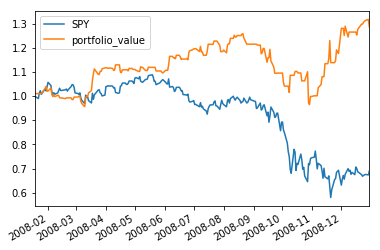

In [69]:
df_trades['portfolio_ret'] = (df_trades['trade'] * df_trades['SPY_ret'])
df_trades['portfolio_value'] = (1 + df_trades['portfolio_ret']).cumprod()
df_trades['SPY'] = df_trades['SPY'] / df_trades.iloc[0]['SPY']

df_trades[['SPY', 'portfolio_value']].plot()

In [88]:
print ("\nPerformances during testing period for {}".format(symbol))
print ("Date Range: {} to {}\n".format(validation_df.iloc[0].name, validation_df.iloc[-1].name))

from util import compute_sharpe_ratio
def get_sharpe(series):

    rfr = (1.03**(1/252.0))-1

    adr = series.mean()
    sddr = series.std()
    return compute_sharpe_ratio(np.sqrt(252), adr, rfr, sddr)

print("Sharpe Ratio of Portfolio: {}".format(get_sharpe(df_trades['portfolio_ret'])))
print("Sharpe Ratio of Benchmark: {}\n".format(get_sharpe(df_trades['SPY_ret'])))

print("Cumulative return of portfolio: {}".format((1+df_trades['portfolio_ret']).prod() - 1))
print("Cumulative return of benchmark: {}\n".format((1+df_trades['SPY_ret']).prod() - 1))

print("Standard Deviation of Portfolio: {}".format(df_trades['portfolio_ret'].std()))
print("Standard Deviation of Benchmark: {}\n".format(df_trades['SPY_ret'].std()))

print("Average Daily Return of Portfolio: {}".format(df_trades['portfolio_ret'].mean()))
print("Average Daily Return of Benchmark: {}\n".format(df_trades['SPY_ret'].mean()))

print("Final Portfolio Value: {}".format(100_000 * df_trades.iloc[-1]['portfolio_value']))
print("Final Benchmark Value: {}".format(100_000 * (1+df_trades['SPY_ret']).cumprod().iloc[-1]))


Performances during testing period for SPY
Date Range: 2008-01-03 00:00:00 to 2008-12-31 00:00:00

Sharpe Ratio of Portfolio: 0.9664082789960003
Sharpe Ratio of Benchmark: -0.8124472725772371

Cumulative return of portfolio: 0.2859339613113452
Cumulative return of benchmark: -0.3171693926193807

Standard Deviation of Portfolio: 0.01795035533393809
Standard Deviation of Benchmark: 0.026521696916875993

Average Daily Return of Portfolio: 0.0012100854335354335
Average Daily Return of Benchmark: -0.0012400599604033109

Final Portfolio Value: 128593.39613113452
Final Benchmark Value: 68283.06073806193
